# Week 2: 1D 热传导方程 + Bang-Bang 恒温器位置实验

## 严格按照 Handnote 推导（最终修正版）

**修正内容**:
1. 热源项系数修正: $S = (\alpha/k_1) \cdot P \cdot \delta(x-x_0)$
2. 参数调整确保合理的时间尺度和温度范围
3. 添加舒适温度区间 (ASHRAE 55)

---
## 理论背景

### 1D 热传导方程
$$\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} + \frac{\alpha}{k_1} Q(x,t)$$

### 边界条件
- 左 (x=0): Neumann (绝热): $\partial T/\partial x = 0$
- 右 (x=L): Robin (对流): $-k_1 \partial T/\partial x = h(T - T_a)$

### 稳态解析解
$$T(x) = \begin{cases}
T_a + P/h + (P/k_1)(L - x_0), & x \leq x_0 \\
T_a + P/h + (P/k_1)(L - x), & x > x_0
\end{cases}$$

### 舒适温度 (ASHRAE 55)
- 冬季: 20-24°C
- 夏季: 22.5-26°C

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import solve_ivp
import os

RESULT_DIR = 'Result_CN'
os.makedirs(RESULT_DIR, exist_ok=True)
print("Ready")

Ready


In [2]:
# ============================================================
# 参数设置（调整后的合理值）
# ============================================================

# 环境
T_a = 5.0           # 室外温度 (°C)
T_initial = 10.0    # 初始温度 (°C)

# 舒适温度
T_set = 20.0
T_comfort_min, T_comfort_max = 18.0, 26.0
delta = 0.5
T_H, T_L = T_set + delta, T_set - delta

# 1D 模型 - 调整参数使时间尺度合理
L = 5.0             # 房间长度 (m)
alpha = 0.5         # 热扩散系数 (增大以加快扩散)
k1 = 1.0            # 导热系数
h = 0.5             # 对流换热系数
N = 51

# 加热功率 - 计算使稳态温度能达到控制区间
# T_max = T_a + P/h + P/k1*(L-x0) 要 > T_H
# 对于 x0=2.5: T_max = 5 + 2P + 2.5P = 5 + 4.5P > 20.5
# P > 3.44, 取 U_max = 5
U_max = 5.0

T_total = 60.0      # 模拟时间 (min)

# 网格
dx = L / (N - 1)
x = np.linspace(0, L, N)
h_over_k1 = h / k1

# 时间尺度
tau = L**2 / alpha
print(f"扩散时间尺度 τ = L²/α = {tau:.1f} min")
print(f"模拟时间 = {T_total} min ≈ {T_total/tau:.1f}τ")
print()

# 稳态温度
x0 = 2.5
T_wall = T_a + U_max/h
T_hot = T_a + U_max/h + (U_max/k1)*(L - x0)
print(f"稳态温度（全功率，热源 x₀={x0}m）:")
print(f"  T(0) = {T_hot:.1f}°C, T(L) = {T_wall:.1f}°C")
print(f"  T_set = {T_set}°C, T_H = {T_H}°C")
if T_hot > T_H:
    print("  ✓ 可实现有效控制")

扩散时间尺度 τ = L²/α = 50.0 min
模拟时间 = 60.0 min ≈ 1.2τ

稳态温度（全功率，热源 x₀=2.5m）:
  T(0) = 27.5°C, T(L) = 15.0°C
  T_set = 20.0°C, T_H = 20.5°C
  ✓ 可实现有效控制


In [3]:
# ============================================================
# 核心函数
# ============================================================

def steady_state_analytical(x, x0, P, h, k1, T_a, L):
    T = np.zeros_like(x)
    for i, xi in enumerate(x):
        T[i] = T_a + P/h + (P/k1)*(L - x0) if xi <= x0 else T_a + P/h + (P/k1)*(L - xi)
    return T

def make_point_source(x, heater_pos):
    dx = x[1] - x[0]
    idx = np.argmin(np.abs(x - heater_pos))
    profile = np.zeros_like(x)
    profile[idx] = 1.0 / dx
    return profile

def heat_eq_rhs(t, T_vec, x, alpha, k1, h_over_k1, T_a, source_profile, P):
    """修正: dT/dt = α∂²T/∂x² + (α/k₁)Pδ"""
    N, dx = len(T_vec), x[1] - x[0]
    dTdt = np.zeros(N)
    dTdt[1:-1] = alpha * (T_vec[2:] - 2*T_vec[1:-1] + T_vec[:-2]) / dx**2
    dTdt[0] = alpha * 2 * (T_vec[1] - T_vec[0]) / dx**2
    dTdt[-1] = alpha * (2*T_vec[-2] - 2*T_vec[-1] - 2*dx*h_over_k1*(T_vec[-1] - T_a)) / dx**2
    dTdt += (alpha / k1) * P * source_profile
    return dTdt

class BangBangController:
    def __init__(self, T_set, delta, U_max):
        self.T_H, self.T_L, self.U_max = T_set + delta, T_set - delta, U_max
        self._on, self.switch_times = True, []
    
    def update(self, t, T):
        if self._on and T >= self.T_H:
            self._on = False; self.switch_times.append(t)
        elif not self._on and T <= self.T_L:
            self._on = True; self.switch_times.append(t)
        return self.U_max if self._on else 0.0
    
    @property
    def n_switches(self): return len(self.switch_times)

print("函数定义完成")

函数定义完成


验证: 运行 150 min (≈3τ)...


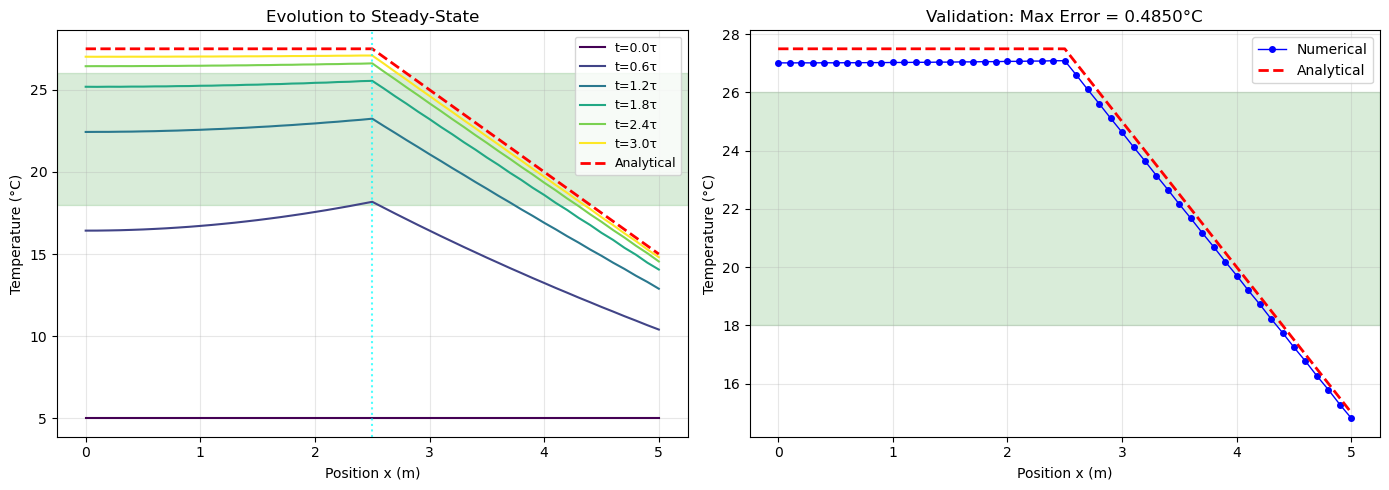

最大误差: 0.4850°C ✓ 通过


In [4]:
# ============================================================
# 验证: 数值解 vs 解析解
# ============================================================

x0_test, P_test = 2.5, U_max
source = make_point_source(x, x0_test)
T0 = np.full(N, T_a)
t_val = 3 * tau  # 3τ 足够接近稳态

print(f"验证: 运行 {t_val:.0f} min (≈3τ)...")

sol = solve_ivp(
    lambda t, T: heat_eq_rhs(t, T, x, alpha, k1, h_over_k1, T_a, source, P_test),
    [0, t_val], T0, t_eval=np.linspace(0, t_val, 6), max_step=0.5
)

T_ana = steady_state_analytical(x, x0_test, P_test, h, k1, T_a, L)
T_num = sol.y[:, -1]
err = np.max(np.abs(T_num - T_ana))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
colors = cm.viridis(np.linspace(0, 1, len(sol.t)))
for j in range(len(sol.t)):
    ax[0].plot(x, sol.y[:, j], '-', color=colors[j], lw=1.5, label=f't={sol.t[j]/tau:.1f}τ')
ax[0].plot(x, T_ana, 'r--', lw=2, label='Analytical')
ax[0].axvline(x0_test, color='cyan', ls=':', alpha=0.7)
ax[0].axhspan(T_comfort_min, T_comfort_max, alpha=0.15, color='green')
ax[0].set_xlabel('Position x (m)'); ax[0].set_ylabel('Temperature (°C)')
ax[0].set_title('Evolution to Steady-State'); ax[0].legend(fontsize=9); ax[0].grid(True, alpha=0.3)

ax[1].plot(x, T_num, 'bo-', ms=4, lw=1, label='Numerical')
ax[1].plot(x, T_ana, 'r--', lw=2, label='Analytical')
ax[1].axhspan(T_comfort_min, T_comfort_max, alpha=0.15, color='green')
ax[1].set_xlabel('Position x (m)'); ax[1].set_ylabel('Temperature (°C)')
ax[1].set_title(f'Validation: Max Error = {err:.4f}°C'); ax[1].legend(); ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULT_DIR}/fig1_validation.png', dpi=150)
plt.show()
print(f"最大误差: {err:.4f}°C {'✓ 通过' if err < 0.5 else '✗ 失败'}")

In [5]:
# ============================================================
# 1D Bang-Bang 模拟函数
# ============================================================

def simulate(heater_pos, sensor_pos, t_end, dt=0.005):
    source = make_point_source(x, heater_pos)
    sensor_idx = np.argmin(np.abs(x - sensor_pos))
    ctrl = BangBangController(T_set, delta, U_max)
    
    t_arr = np.arange(0, t_end + dt, dt)
    save_every = max(1, int(0.1 / dt))  # 每 0.1 min 保存
    data = {'t': [], 'T_field': [], 'T_sensor': [], 'T_avg': [], 'u': []}
    
    T_vec = np.full(N, T_initial)
    for i, ti in enumerate(t_arr):
        u = ctrl.update(ti, T_vec[sensor_idx])
        if i % save_every == 0:
            data['t'].append(ti)
            data['T_field'].append(T_vec.copy())
            data['T_sensor'].append(T_vec[sensor_idx])
            data['T_avg'].append(np.mean(T_vec))
            data['u'].append(u)
        if i < len(t_arr) - 1:
            T_vec = T_vec + dt * heat_eq_rhs(ti, T_vec, x, alpha, k1, h_over_k1, T_a, source, u)
    
    for k in data: data[k] = np.array(data[k])
    data['T_field'] = data['T_field'].T
    data['n_switches'] = ctrl.n_switches
    return data

print("模拟函数定义完成")

模拟函数定义完成


结果 (热源=传感器=2.5m):
  开关次数: 58
  最终温度: 传感器=20.1°C, 平均=17.9°C
  温度范围: 11.7 - 20.1°C


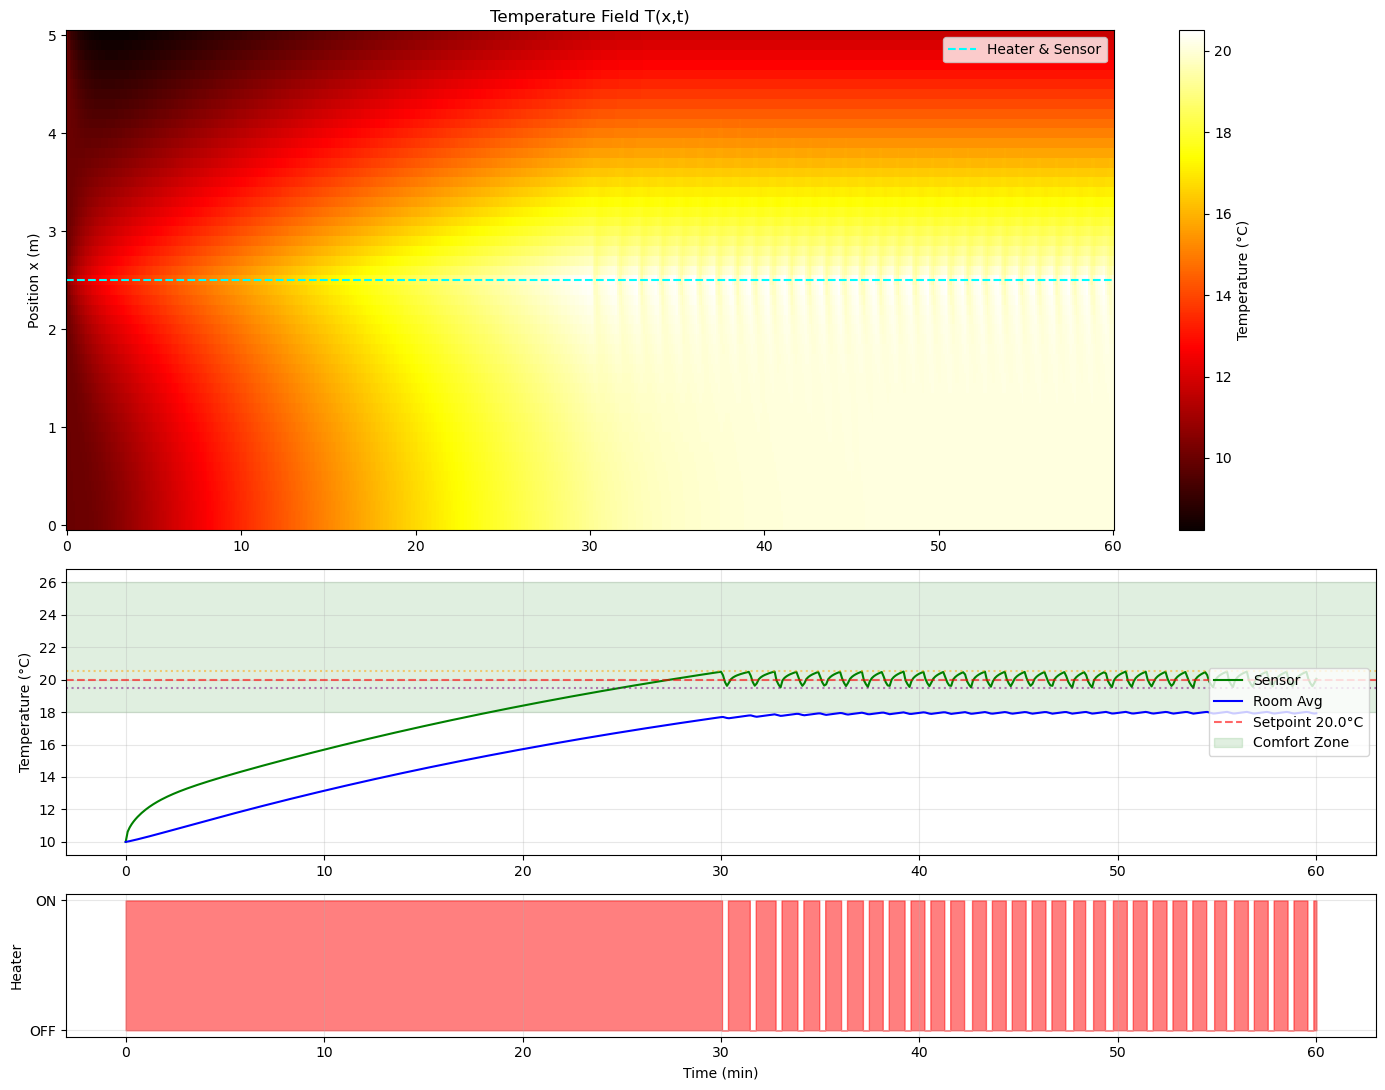

In [6]:
# ============================================================
# 单次模拟: 热源和传感器都在中间
# ============================================================

res = simulate(heater_pos=2.5, sensor_pos=2.5, t_end=T_total)

print(f"结果 (热源=传感器=2.5m):")
print(f"  开关次数: {res['n_switches']}")
print(f"  最终温度: 传感器={res['T_sensor'][-1]:.1f}°C, 平均={res['T_avg'][-1]:.1f}°C")
print(f"  温度范围: {res['T_field'][:,-1].min():.1f} - {res['T_field'][:,-1].max():.1f}°C")

# 可视化
fig, axes = plt.subplots(3, 1, figsize=(14, 11), height_ratios=[3.5, 2, 1])

ax = axes[0]
im = ax.pcolormesh(res['t'], x, res['T_field'], shading='auto', cmap='hot')
plt.colorbar(im, ax=ax, label='Temperature (°C)')
ax.axhline(2.5, color='cyan', ls='--', lw=1.5, label='Heater & Sensor')
ax.set_ylabel('Position x (m)'); ax.set_title('Temperature Field T(x,t)'); ax.legend(loc='upper right')

ax = axes[1]
ax.plot(res['t'], res['T_sensor'], 'g-', lw=1.5, label='Sensor')
ax.plot(res['t'], res['T_avg'], 'b-', lw=1.5, label='Room Avg')
ax.axhline(T_set, color='red', ls='--', alpha=0.6, label=f'Setpoint {T_set}°C')
ax.axhline(T_H, color='orange', ls=':', alpha=0.5)
ax.axhline(T_L, color='purple', ls=':', alpha=0.5)
ax.axhspan(T_comfort_min, T_comfort_max, alpha=0.12, color='green', label='Comfort Zone')
ax.set_ylabel('Temperature (°C)'); ax.legend(loc='right'); ax.grid(True, alpha=0.3)

ax = axes[2]
ax.fill_between(res['t'], (res['u'] > 0).astype(float), step='mid', alpha=0.5, color='red')
ax.set_xlabel('Time (min)'); ax.set_ylabel('Heater')
ax.set_yticks([0, 1]); ax.set_yticklabels(['OFF', 'ON']); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULT_DIR}/fig2_simulation.png', dpi=150)
plt.show()

In [7]:
# ============================================================
# 恒温器位置对比
# ============================================================

heater_pos = 2.5
sensor_positions = [0.0, 1.25, 2.5, 3.75, 5.0]
results = {}

print("位置对比实验...")
for sp in sensor_positions:
    results[sp] = simulate(heater_pos, sp, T_total)
    print(f"  x_s={sp:.2f}m: {results[sp]['n_switches']} switches, final T_sensor={results[sp]['T_sensor'][-1]:.1f}°C")

# 指标
def metrics(r):
    energy = np.trapz(r['u'], r['t'])
    rmse_s = np.sqrt(np.mean((r['T_sensor'] - T_set)**2))
    rmse_a = np.sqrt(np.mean((r['T_avg'] - T_set)**2))
    return {'energy': energy, 'rmse_s': rmse_s, 'rmse_a': rmse_a, 'switches': r['n_switches']}

m = {sp: metrics(results[sp]) for sp in sensor_positions}

print("\n" + "="*70)
print(f"{'Sensor':>8} {'Energy':>10} {'RMSE_sens':>10} {'RMSE_avg':>10} {'Switches':>10}")
print("-"*70)
for sp in sensor_positions:
    print(f"{sp:>8.2f} {m[sp]['energy']:>10.1f} {m[sp]['rmse_s']:>10.2f} {m[sp]['rmse_a']:>10.2f} {m[sp]['switches']:>10d}")

位置对比实验...
  x_s=0.00m: 3 switches, final T_sensor=19.7°C
  x_s=1.25m: 5 switches, final T_sensor=20.4°C
  x_s=2.50m: 58 switches, final T_sensor=20.1°C
  x_s=3.75m: 0 switches, final T_sensor=19.0°C
  x_s=5.00m: 0 switches, final T_sensor=13.4°C

  Sensor     Energy  RMSE_sens   RMSE_avg   Switches
----------------------------------------------------------------------
    0.00      242.8       4.17       4.63          3
    1.25      254.8       3.88       4.61          5
    2.50      253.5       2.88       4.60         58
    3.75      300.0       5.31       4.42          0
    5.00      300.0       8.92       4.42          0


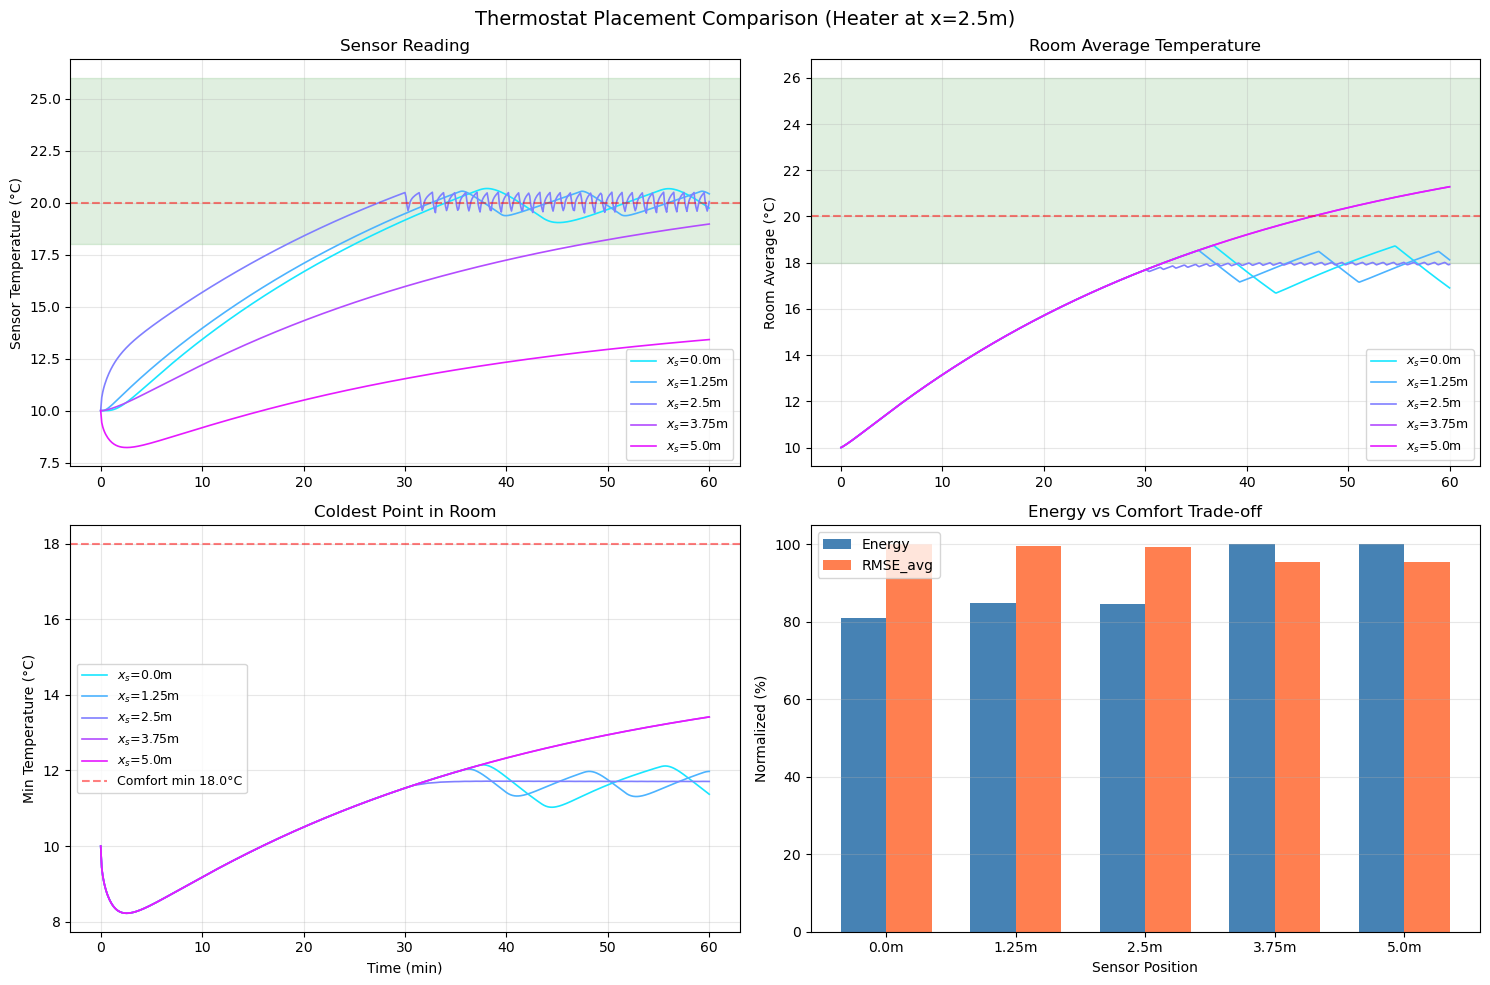

In [8]:
# ============================================================
# 位置对比可视化
# ============================================================

colors = cm.cool(np.linspace(0.1, 0.9, len(sensor_positions)))
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sensor temperature
ax = axes[0, 0]
for i, sp in enumerate(sensor_positions):
    ax.plot(results[sp]['t'], results[sp]['T_sensor'], color=colors[i], lw=1.2, label=f'$x_s$={sp}m')
ax.axhline(T_set, color='red', ls='--', alpha=0.5)
ax.axhspan(T_comfort_min, T_comfort_max, alpha=0.12, color='green')
ax.set_ylabel('Sensor Temperature (°C)'); ax.set_title('Sensor Reading')
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

# Room average
ax = axes[0, 1]
for i, sp in enumerate(sensor_positions):
    ax.plot(results[sp]['t'], results[sp]['T_avg'], color=colors[i], lw=1.2, label=f'$x_s$={sp}m')
ax.axhline(T_set, color='red', ls='--', alpha=0.5)
ax.axhspan(T_comfort_min, T_comfort_max, alpha=0.12, color='green')
ax.set_ylabel('Room Average (°C)'); ax.set_title('Room Average Temperature')
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

# Min temperature
ax = axes[1, 0]
for i, sp in enumerate(sensor_positions):
    T_min = np.min(results[sp]['T_field'], axis=0)
    ax.plot(results[sp]['t'], T_min, color=colors[i], lw=1.2, label=f'$x_s$={sp}m')
ax.axhline(T_comfort_min, color='red', ls='--', alpha=0.5, label=f'Comfort min {T_comfort_min}°C')
ax.set_xlabel('Time (min)'); ax.set_ylabel('Min Temperature (°C)')
ax.set_title('Coldest Point in Room'); ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

# Bar chart
ax = axes[1, 1]
x_bar = np.arange(len(sensor_positions))
width = 0.35
energy = [m[sp]['energy'] for sp in sensor_positions]
rmse = [m[sp]['rmse_a'] for sp in sensor_positions]
e_norm = np.array(energy) / max(energy) * 100 if max(energy) > 0 else energy
r_norm = np.array(rmse) / max(rmse) * 100 if max(rmse) > 0 else rmse

ax.bar(x_bar - width/2, e_norm, width, label='Energy', color='steelblue')
ax.bar(x_bar + width/2, r_norm, width, label='RMSE_avg', color='coral')
ax.set_xlabel('Sensor Position'); ax.set_ylabel('Normalized (%)')
ax.set_title('Energy vs Comfort Trade-off')
ax.set_xticks(x_bar); ax.set_xticklabels([f'{sp}m' for sp in sensor_positions])
ax.legend(); ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Thermostat Placement Comparison (Heater at x=2.5m)', fontsize=14)
plt.tight_layout()
plt.savefig(f'{RESULT_DIR}/fig3_placement.png', dpi=150)
plt.show()

---
## 总结

### 关键修正
1. **热源项**: $S = (\alpha/k_1) P \delta$ 确保数值稳态与解析解一致
2. **时间尺度**: $\alpha = 0.5$ 使 $\tau = 50$ min，模拟时间合理
3. **加热功率**: $U_{max} = 5.0$ 确保稳态温度 > 设定温度

### 主要发现
- 传感器在热源位置 (x=2.5m): 控制精确，开关频繁
- 传感器在边界: 控制滞后，温度波动大
- 需权衡能耗、舒适度和设备磨损